In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

# import test metrics

In [180]:
# import LCE and XGB test metrics
lce = pd.read_csv('/workspace/data/SGU/SFSI/SFSI/LCE10x_akermark_7class/20231113092344/LCE_test_metrics.csv', sep= ',', decimal = '.')
xgb = pd.read_csv('/workspace/data/SGU/SFSI/SFSI/XBG10x_akermark_7class/20231115122858/XGB_test_metrics.csv', sep= ',', decimal = '.')
# read MCC
lce = lce['MCC (Test)'].to_numpy()
xgb = xgb['MCC (Test)'].to_numpy()
x = np.column_stack((lce, xgb))
x.ndim, x

(2,
 array([[0.53062423, 0.52096284],
        [0.55101806, 0.51206485],
        [0.55690232, 0.54027353],
        [0.55588164, 0.54610088],
        [0.52005454, 0.51058592],
        [0.5347537 , 0.50792629],
        [0.54722927, 0.53314007],
        [0.54211315, 0.51469714],
        [0.53521571, 0.51472932],
        [0.57279404, 0.53421601],
        [0.56429427, 0.53183579],
        [0.54426472, 0.51842427],
        [0.54231445, 0.53152876],
        [0.55101406, 0.5270134 ],
        [0.56120906, 0.53577786],
        [0.53764279, 0.51035627],
        [0.54634859, 0.51743331],
        [0.54582616, 0.52481188],
        [0.54743581, 0.51972172],
        [0.54740421, 0.52732193],
        [0.5325066 , 0.51335505],
        [0.53868929, 0.52228939],
        [0.52901288, 0.51318329],
        [0.53232694, 0.51658832],
        [0.52804001, 0.49601646],
        [0.54542411, 0.52070326],
        [0.54088686, 0.51917705],
        [0.5387648 , 0.51939335],
        [0.5618621 , 0.53204986],
        [0

# plot distribution

LCE mean:  0.5424371549553793


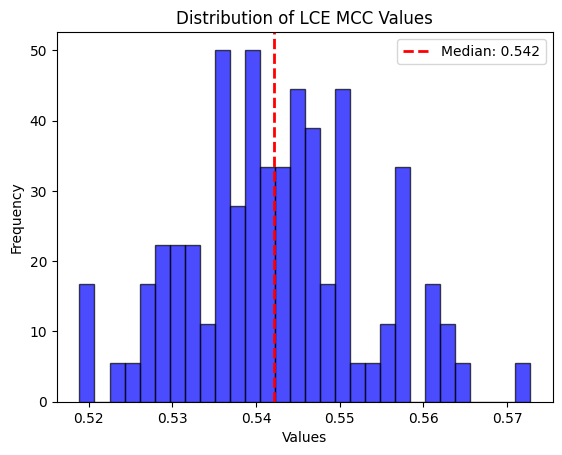

In [181]:
plt.hist(lce, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
# Display median value
median_value = np.median(lce)
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.3f}')
plt.title('Distribution of LCE MCC Values')
plt.legend()

print('LCE mean: ', lce.mean())

0.5210109895487532

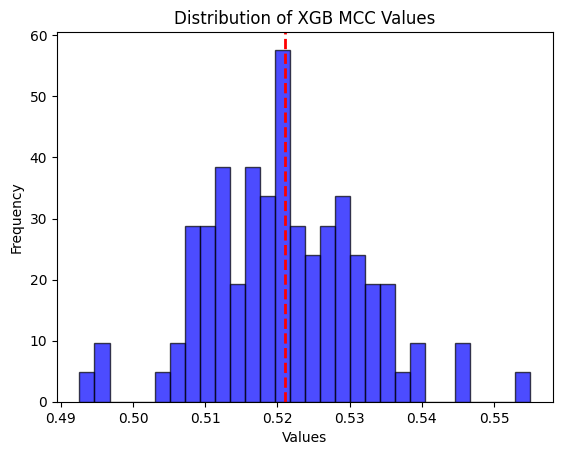

In [182]:
plt.hist(xgb, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
# Display median value
median_value = np.median(xgb)
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.3f}')
plt.title('Distribution of LCE MCC Values')
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of XGB MCC Values')
xgb.mean()

In [183]:
def correlated_ttest(x, rope, runs=1, verbose=False, names=('C1', 'C2')):
    import scipy.stats as stats
    """
    Compute correlated t-test
 
    The function uses the Bayesian interpretation of the p-value and returns
    the probabilities the difference are below `-rope`, within `[-rope, rope]`
    and above the `rope`. For details, see `A Bayesian approach for comparing
    cross-validated algorithms on multiple data sets
    <http://link.springer.com/article/10.1007%2Fs10994-015-5486-z>`_,
    G. Corani and A. Benavoli, Mach Learning 2015.
 
    |
    The test assumes that the classifiers were evaluated using cross
    validation. The number of folds is determined from the length of the vector
    of differences, as `len(diff) / runs`. The variance includes a correction
    for underestimation of variance due to overlapping training sets, as
    described in `Inference for the Generalization Error
    <http://link.springer.com/article/10.1023%2FA%3A1024068626366>`_,
    C. Nadeau and Y. Bengio, Mach Learning 2003.)
 
    |
    Args:
    x (array): a vector of differences or a 2d array with pairs of scores.
    rope (float): the width of the rope  
    runs (int): number of repetitions of cross validation (default: 1)
    return: probablities (tuple) that differences are below -rope, within rope or
        above rope
    """
    if x.ndim == 2:
        x = x[:, 1] - x[:, 0]
    diff=x
    n = len(diff)
    nfolds = n / runs
    x = np.mean(diff)
    # Nadeau's and Bengio's corrected variance
    var = np.var(diff, ddof=1) * (1 / n + 1 / (nfolds - 1))
    if var == 0:
        return int(x < rope), int(-rope <= x <= rope), int(rope < x)
    pr = 1-stats.t.cdf(rope, n - 1, x, np.sqrt(var))
    pl = stats.t.cdf(-rope, n - 1, x, np.sqrt(var))
    pe=1-pl-pr
    if verbose:
        print('P({c1} > {c2}) = {pl}, P(rope) = {pe}, P({c2} > {c1}) = {pr}'.
              format(c1=names[0], c2=names[1], pl=pl, pe=pe, pr=pr))
    return pl, pe, pr

In [184]:
names = ['LCE', 'XGB']
rope=0.01
left, within, right = correlated_ttest(x, rope=rope,runs=1,verbose=True,names=names)

P(LCE > XGB) = 0.9999999999999999, P(rope) = 1.1102230246251565e-16, P(XGB > LCE) = 0.0


((1.0, 0.0, 0.0), <Figure size 640x480 with 1 Axes>)

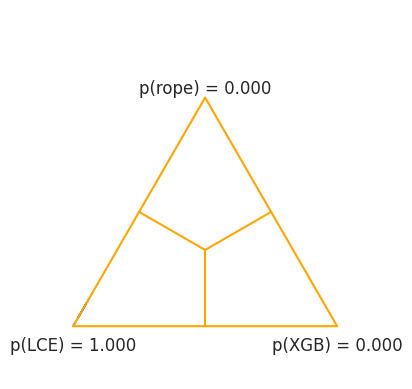

In [185]:
from baycomp import two_on_multiple
two_on_multiple(lce, xgb, rope=0.01, runs=100, names = ['LCE', 'XGB'], plot=True)

In [186]:
def correlated_ttest_MC(x, rope, runs=1,  nsamples=50000):
    """
    See correlated_ttest module for explanations
    """
    if x.ndim == 2:
        x = x[:, 1] - x[:, 0]
    diff=x
    n = len(diff)
    nfolds = n / runs
    x = np.mean(diff)
    # Nadeau's and Bengio's corrected variance
    var = np.var(diff, ddof=1) * (1 / n + 1 / (nfolds - 1))
    if var == 0:
        return int(x < rope), int(-rope <= x <= rope), int(rope < x)
    
    return x+np.sqrt(var)*np.random.standard_t( n - 1, nsamples)

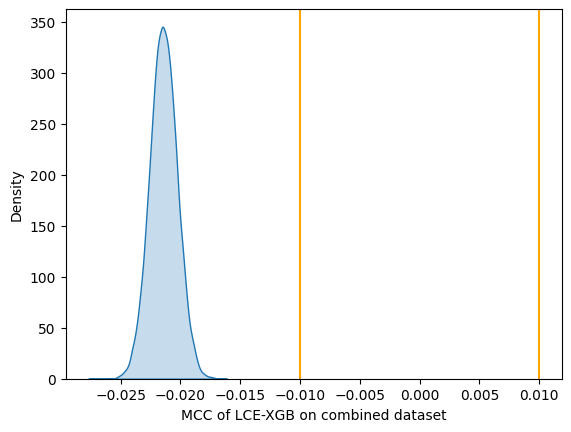

In [187]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as snb
#generate samples from posterior (it is not necesssary because the posterior is a Student)
samples=correlated_ttest_MC(x, rope=rope,runs=1,nsamples=50000)
#plot posterior
snb.kdeplot(samples, shade=True) 
#plot rope region
plt.axvline(x=-rope,color='orange')
plt.axvline(x=rope,color='orange')
#add label
plt.xlabel('MCC of LCE-XGB on combined dataset');